# Skin Cancer Classification

## Import Relevant Packages

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL.Image as img
from keras.layers import Dense, Conv2D , MaxPool2D , Dropout , Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns

## Read in Dataset

In [35]:
data = pd.read_csv("./hmnist_28_28_L.csv")
metadata = pd.read_csv("./HAM10000_metadata.csv")

# Normalize data:
data_normalized = data / 255

data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


## Metadata Analysis

In [25]:
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

Good to know! It looks like we've got 57 cases whose age was not recorded. This is a low enough number that I feel comfy replacing these missing ages with the mean age across the whole dataset.

In [26]:
# Fill na values "age" variable
metadata["age"].fillna(metadata["age"].mean(), inplace = True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [24]:
# Check work with .describe:
metadata["age"].describe()

count    10015.000000
mean        51.863828
std         16.920252
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

Interesting... we have some cases where the recorded age is zero!! It's unlikely (I think, at least; I'm not really an expert in pediatric oncology) to have a patient who is truly less than a year old in for skin cancer, so I'm going to assume that these cases are simply a mixup in data entry -- some unknown ages were input as NA, some unknown ages were input as 0. Let's fix that too.

#### First, let's check how many 0s we have....

In [32]:
metadata["age"].value_counts()[0]

39

Well that's okay, only 39 zeros! I wanted to check and make sure -- it's always nasty if they make up some absurd number like 1/2 the dataset!

In [33]:
metadata["age"] = metadata["age"].replace(0, metadata["age"].mean())
metadata["age"].describe()

count    10015.000000
mean        52.065794
std         16.606576
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [10]:
data.groupby("label").count()["pixel0001"]

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: pixel0001, dtype: int64

We normalize the dataset because we want to get a value as a *percentage* of brightness, rather than a specific luma key. I've done some analysis on this to know that we don't have any issues, as would be expected for a dataset cultivated for machine learning rather than "real-world" data. I'll likely do more to figure out what kind of distributions exist across cancer type, gender, cancer location, etc. For now though, let's do the fun stuff!

## Let's plot the first few images

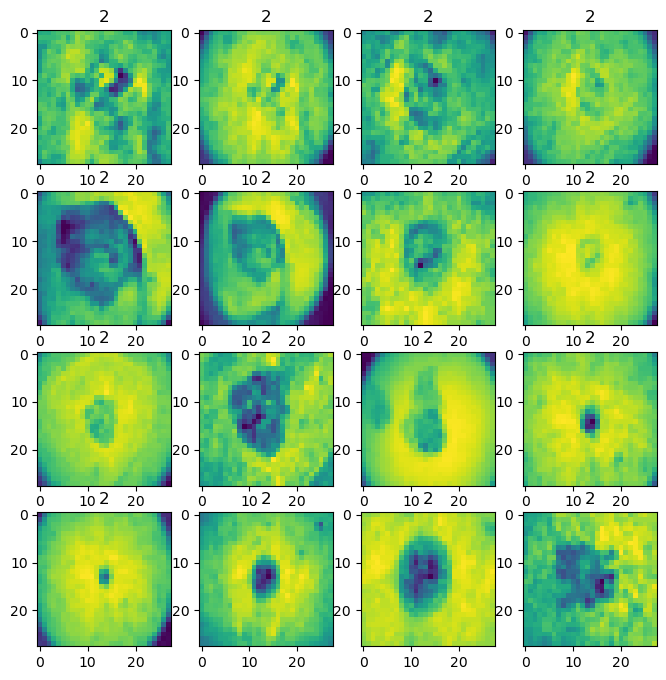

In [7]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data_normalized.iloc[i,:784].values.reshape(28,28))
    plt.title(data.iloc[i,784])

Well this is cool! I really love being able to take a look at what the computer "sees" when I give it the matrix. I also just noticed something about the data that I'll have to fix -- I normalized EVERY column in the dataset, including the label column. Probably a good idea to fix that little issue...